# FRED Quickstart

This notebook introduces Federal Reserve Economic Data (FRED) and shows how to:

- Pull macroeconomic data via Python
- Inspect and sanity check the data
- Create simple time-series visualizations

This is an onboarding notebook — no modeling, no signals yet.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path

import pandas_datareader.data as web

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_RAW.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
START_DATE = "1990-01-01"
END_DATE = datetime.today().strftime("%Y-%m-%d")

START_DATE, END_DATE

('1990-01-01', '2026-01-19')

## What is FRED?

FRED (Federal Reserve Economic Data) is a public database maintained by the
Federal Reserve Bank of St. Louis.

It provides thousands of macroeconomic time series including:
- Growth
- Inflation
- Labor markets
- Interest rates
- Financial conditions

We will start with a small, commonly used core set.

In [3]:
SERIES = {
    "GDP": "GDP",            # Real GDP (Quarterly)
    "CPI": "CPIAUCSL",       # CPI (Monthly)
    "UNRATE": "UNRATE",      # Unemployment Rate (Monthly)
    "FEDFUNDS": "FEDFUNDS",  # Effective Fed Funds Rate (Monthly)
}

SERIES

{'GDP': 'GDP', 'CPI': 'CPIAUCSL', 'UNRATE': 'UNRATE', 'FEDFUNDS': 'FEDFUNDS'}

In [4]:
fred_ids = list(SERIES.values())

data = web.DataReader(
    fred_ids,
    "fred",
    start=START_DATE,
    end=END_DATE
)

# Rename columns to short, clean names
data.columns = list(SERIES.keys())

data.tail()

,GDP,CPI,UNRATE,FEDFUNDS
DATE,,,,
2025-08-01,NaN,323.364,4.3,4.33
2025-09-01,NaN,324.368,4.4,4.22
2025-10-01,NaN,NaN,NaN,4.09
2025-11-01,NaN,325.031,4.5,3.88
2025-12-01,NaN,326.030,4.4,3.72


In [5]:
print("Shape:", data.shape)
display(data.info())
display(data.describe().T)

Shape: (432, 4)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 432 entries, 1990-01-01 to 2025-12-01
Freq: MS
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GDP       143 non-null    float64
 1   CPI       431 non-null    float64
 2   UNRATE    431 non-null    float64
 3   FEDFUNDS  432 non-null    float64
dtypes: float64(4)
memory usage: 16.9 KB


None

,count,mean,std,min,25%,50%,75%,max
GDP,143.0,14916.229594,6660.743389,5872.701,9352.8365,14430.902,18991.0090,31095.089
CPI,431.0,209.995032,51.525537,127.500,164.5500,211.398,242.3315,326.030
UNRATE,431.0,5.677262,1.741716,3.400,4.4000,5.400,6.6000,14.800
FEDFUNDS,432.0,2.879259,2.343193,0.050,0.2350,2.620,5.2200,8.290


In [6]:
missing = data.isna().sum()
missing

GDP         289
CPI           1
UNRATE        1
FEDFUNDS      0
dtype: int64

## A note on frequency

- GDP is quarterly
- CPI, UNRATE, and FEDFUNDS are monthly

For simple exploration, we will convert everything to monthly frequency
and forward-fill GDP values.

In [7]:
monthly = data.resample("M").last()

# Forward-fill GDP (quarterly → monthly)
monthly["GDP"] = monthly["GDP"].ffill()

monthly.tail()

C:\Users\JR\AppData\Local\Temp\ipykernel_6576\374864869.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = data.resample("M").last()


,GDP,CPI,UNRATE,FEDFUNDS
DATE,,,,
2025-08-31,31095.089,323.364,4.3,4.33
2025-09-30,31095.089,324.368,4.4,4.22
2025-10-31,31095.089,NaN,NaN,4.09
2025-11-30,31095.089,325.031,4.5,3.88
2025-12-31,31095.089,326.030,4.4,3.72


In [8]:
monthly.isna().sum()

GDP         0
CPI         1
UNRATE      1
FEDFUNDS    0
dtype: int64

In [9]:
# ensure canonical raw data directory exists
DATA_RAW.mkdir(parents=True, exist_ok=True)

# save raw and processed monthly data
data.to_csv(DATA_RAW / "fred_raw.csv")
monthly.to_csv(DATA_RAW / "fred_monthly.csv")

print("Saved:")
print(f"- {DATA_RAW / 'fred_raw.csv'}")
print(f"- {DATA_RAW / 'fred_monthly.csv'}")

Saved:
- c:\Users\JR\OneDrive\Mini PC\FRED\data\raw\fred_raw.csv
- c:\Users\JR\OneDrive\Mini PC\FRED\data\raw\fred_monthly.csv


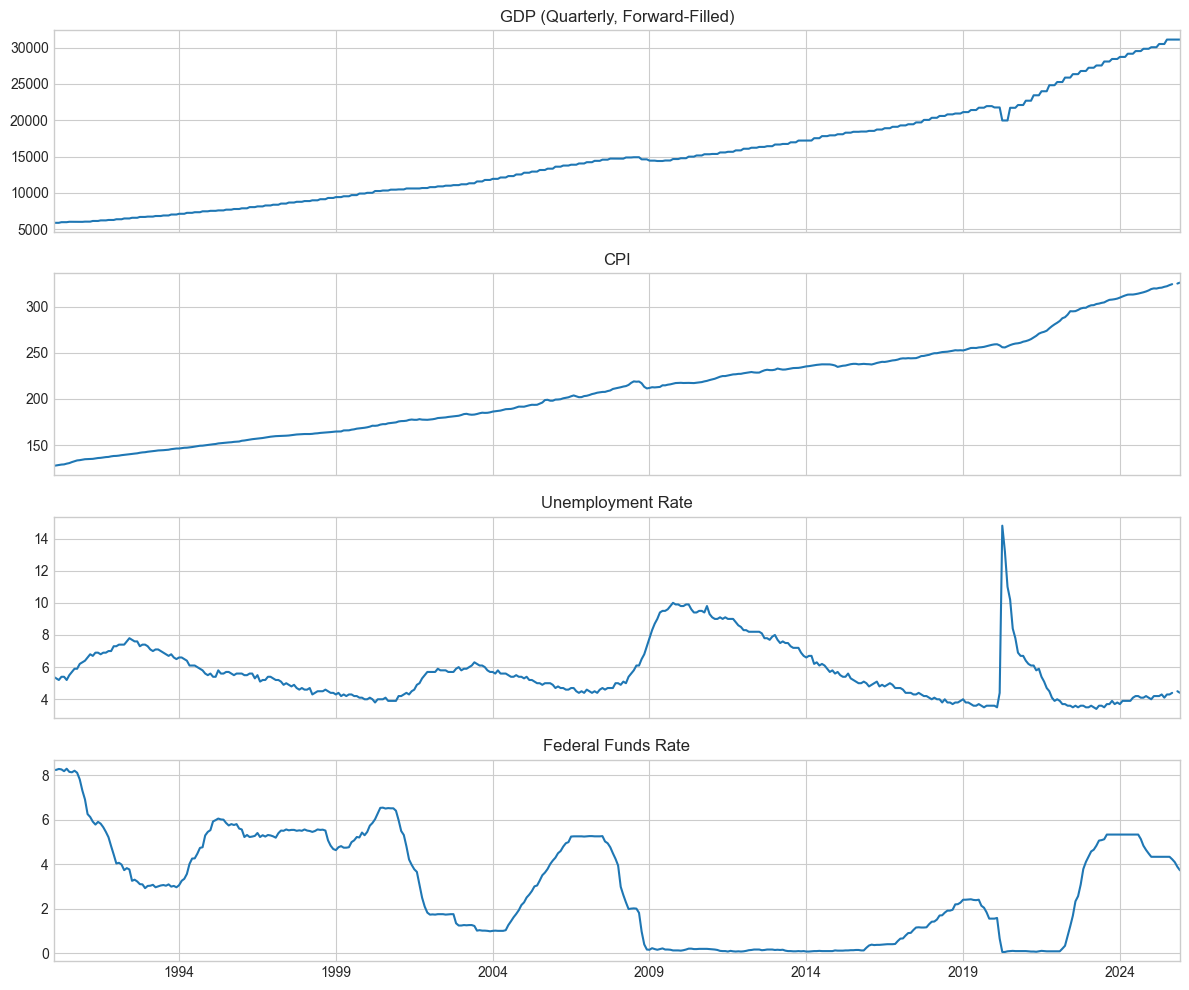

In [10]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

monthly["GDP"].plot(ax=axes[0], title="GDP (Quarterly, Forward-Filled)")
monthly["CPI"].plot(ax=axes[1], title="CPI")
monthly["UNRATE"].plot(ax=axes[2], title="Unemployment Rate")
monthly["FEDFUNDS"].plot(ax=axes[3], title="Federal Funds Rate")

for ax in axes:
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

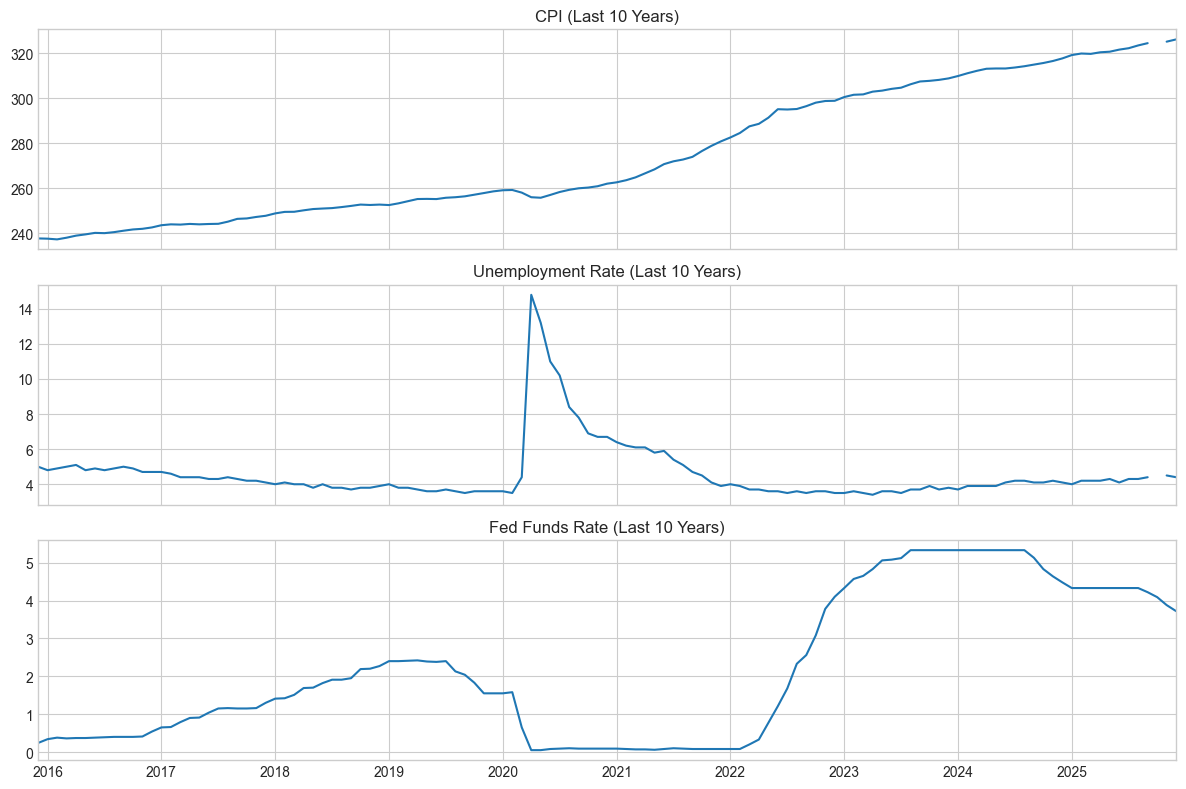

In [11]:
last_10y = monthly.loc[monthly.index >= monthly.index.max() - pd.DateOffset(years=10)]

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

last_10y["CPI"].plot(ax=axes[0], title="CPI (Last 10 Years)")
last_10y["UNRATE"].plot(ax=axes[1], title="Unemployment Rate (Last 10 Years)")
last_10y["FEDFUNDS"].plot(ax=axes[2], title="Fed Funds Rate (Last 10 Years)")

for ax in axes:
    ax.set_xlabel("")

plt.tight_layout()
plt.show()